In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import visualize
from mrcnn.model import *
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
import os
import random
import datetime
import re
import math
import logging
from collections import OrderedDict
import multiprocessing
import numpy as np
import tensorflow as tf
import keras
import keras.backend as K
import keras.layers as KL
import keras.engine as KE
import keras.models as KM

class Mask_RCNN():

    def __init__(self, mode, config, model_dir):
        self.mode = mode
        self.config = config
        self.model_dir = model_dir
        self.set_log_dir()
        self.keras_model = self.build(mode=mode, config=config)
        
    def build(self, mode, config):

        # Inputs
        input_image = KL.Input(
            shape=[None, None, config.IMAGE_SHAPE[2]], name="input_image")
        input_image_meta = KL.Input(shape=[config.IMAGE_META_SIZE],
                                    name="input_image_meta")

        # Anchors in normalized coordinates
        input_anchors = KL.Input(shape=[None, 4], name="input_anchors")
        
        architecture = "resnet101"
        train_bn = config.TRAIN_BN
        
        # Stage 1
        x = KL.ZeroPadding2D((3, 3))(input_image)
        x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
        x = BatchNorm(name='bn_conv1')(x, training=train_bn)
        x = KL.Activation('relu')(x)
        x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
        # Stage 2
        x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
        x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
        C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
        # Stage 3
        x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
        C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
        # Stage 4
        x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
        block_count = {"resnet50": 5, "resnet101": 22}[architecture]
        for i in range(block_count):
            x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
        C4 = x
        # Stage 5
        x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
        x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
        C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)

        P5 = KL.Conv2D(256, (1, 1), name='fpn_c5p5')(C5)
        P4 = KL.Add(name="fpn_p4add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
            KL.Conv2D(256, (1, 1), name='fpn_c4p4')(C4)])
        P3 = KL.Add(name="fpn_p3add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
            KL.Conv2D(256, (1, 1), name='fpn_c3p3')(C3)])
        P2 = KL.Add(name="fpn_p2add")([
            KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
            KL.Conv2D(256, (1, 1), name='fpn_c2p2')(C2)])
        # Attach 3x3 conv to all P layers to get the final feature maps.
        P2 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p2")(P2)
        P3 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p3")(P3)
        P4 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p4")(P4)
        P5 = KL.Conv2D(256, (3, 3), padding="SAME", name="fpn_p5")(P5)
        # P6 is used for the 5th anchor scale in RPN. Generated by
        # subsampling from P5 with stride of 2.
        P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)

        # Note that P6 is used in RPN, but not in the classifier heads.
        rpn_feature_maps = [P2, P3, P4, P5, P6]
        mrcnn_feature_maps = [P2, P3, P4, P5]

        anchors = input_anchors

        # RPN Model
        input_feature_map = KL.Input(shape=[None, None, 256], name="input_rpn_feature_map")
        outputs = rpn_graph(input_feature_map, 3, 1)
        rpn = KM.Model([input_feature_map], outputs, name="rpn_model")
                
        # Loop through pyramid layers
        layer_outputs = []  # list of lists
        for p in rpn_feature_maps:
            layer_outputs.append(rpn([p]))
        # Concatenate layer outputs
        # Convert from list of lists of level outputs to list of lists
        # of outputs across levels.
        # e.g. [[a1, b1, c1], [a2, b2, c2]] => [[a1, a2], [b1, b2], [c1, c2]]
        output_names = ["rpn_class_logits", "rpn_class", "rpn_bbox"]
        outputs = list(zip(*layer_outputs))
        outputs = [KL.Concatenate(axis=1, name=n)(list(o))
                   for o, n in zip(outputs, output_names)]

        rpn_class_logits, rpn_class, rpn_bbox = outputs

        # Generate proposals
        # Proposals are [batch, N, (y1, x1, y2, x2)] in normalized coordinates
        # and zero padded.
        proposal_count = 1000
        rpn_rois = ProposalLayer(
            proposal_count = proposal_count,
            nms_threshold = 0.7,
            name = "ROI",
            config=config)([rpn_class, rpn_bbox, anchors])


        # Network Heads
        # Proposal classifier and BBox regressor heads
        mrcnn_class_logits, mrcnn_class, mrcnn_bbox =\
            fpn_classifier_graph(rpn_rois, mrcnn_feature_maps, input_image_meta,
                                 config.POOL_SIZE, config.NUM_CLASSES,
                                 train_bn=config.TRAIN_BN,
                                 fc_layers_size=config.FPN_CLASSIF_FC_LAYERS_SIZE)

        # Detections
        # output is [batch, num_detections, (y1, x1, y2, x2, class_id, score)] in
        # normalized coordinates
        detections = DetectionLayer(config, name="mrcnn_detection")(
            [rpn_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

        # Create masks for detections
        detection_boxes = KL.Lambda(lambda x: x[..., :4])(detections)
        
        # MASK
        
        # ROI Pooling
        x = PyramidROIAlign([14, 14],
                        name="roi_align_mask")([detection_boxes, input_image_meta] + mrcnn_feature_maps)

        # Conv layers
        x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                               name="mrcnn_mask_conv1")(x)
        x = KL.TimeDistributed(BatchNorm(),
                               name='mrcnn_mask_bn1')(x, training=train_bn)
        x = KL.Activation('relu')(x)

        x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                               name="mrcnn_mask_conv2")(x)
        x = KL.TimeDistributed(BatchNorm(),
                               name='mrcnn_mask_bn2')(x, training=train_bn)
        x = KL.Activation('relu')(x)

        x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                               name="mrcnn_mask_conv3")(x)
        x = KL.TimeDistributed(BatchNorm(),
                               name='mrcnn_mask_bn3')(x, training=train_bn)
        x = KL.Activation('relu')(x)

        x = KL.TimeDistributed(KL.Conv2D(256, (3, 3), padding="same"),
                               name="mrcnn_mask_conv4")(x)
        x = KL.TimeDistributed(BatchNorm(),
                               name='mrcnn_mask_bn4')(x, training=train_bn)
        x = KL.Activation('relu')(x)

        x = KL.TimeDistributed(KL.Conv2DTranspose(256, (2, 2), strides=2, activation="relu"),
                               name="mrcnn_mask_deconv")(x)
        x = KL.TimeDistributed(KL.Conv2D(config.NUM_CLASSES, (1, 1), strides=1, activation="sigmoid"),
                               name="mrcnn_mask")(x)
        
        mrcnn_mask = x

        model = KM.Model([input_image, input_image_meta, input_anchors],
                         [detections, mrcnn_class, mrcnn_bbox,
                             mrcnn_mask, rpn_rois, rpn_class, rpn_bbox],
                         name='mask_rcnn')

        return model




    def load_weights(self, filepath, by_name=False, exclude=None):
        """Modified version of the corresponding Keras function with
        the addition of multi-GPU support and the ability to exclude
        some layers from loading.
        exclude: list of layer names to exclude
        """
        import h5py
        # Conditional import to support versions of Keras before 2.2
        # TODO: remove in about 6 months (end of 2018)
        try:
            from keras.engine import saving
        except ImportError:
            # Keras before 2.2 used the 'topology' namespace.
            from keras.engine import topology as saving

        if exclude:
            by_name = True

        if h5py is None:
            raise ImportError('`load_weights` requires h5py.')
        f = h5py.File(filepath, mode='r')
        if 'layer_names' not in f.attrs and 'model_weights' in f:
            f = f['model_weights']

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        keras_model = self.keras_model
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        # Exclude some layers
        if exclude:
            layers = filter(lambda l: l.name not in exclude, layers)

        if by_name:
            saving.load_weights_from_hdf5_group_by_name(f, layers)
        else:
            saving.load_weights_from_hdf5_group(f, layers)
        if hasattr(f, 'close'):
            f.close()

        # Update the log directory
        self.set_log_dir(filepath)

    def get_imagenet_weights(self):
        """Downloads ImageNet trained weights from Keras.
        Returns path to weights file.
        """
        from keras.utils.data_utils import get_file
        TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/'\
                                 'releases/download/v0.2/'\
                                 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
        weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                TF_WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
        return weights_path

    def compile(self, learning_rate, momentum):
        """Gets the model ready for training. Adds losses, regularization, and
        metrics. Then calls the Keras compile() function.
        """
        # Optimizer object
        optimizer = keras.optimizers.SGD(
            lr=learning_rate, momentum=momentum,
            clipnorm=self.config.GRADIENT_CLIP_NORM)
        # Add Losses
        # First, clear previously set losses to avoid duplication
        self.keras_model._losses = []
        self.keras_model._per_input_losses = {}
        loss_names = [
            "rpn_class_loss",  "rpn_bbox_loss",
            "mrcnn_class_loss", "mrcnn_bbox_loss", "mrcnn_mask_loss"]
        for name in loss_names:
            layer = self.keras_model.get_layer(name)
            if layer.output in self.keras_model.losses:
                continue
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.add_loss(loss)

        # Add L2 Regularization
        # Skip gamma and beta weights of batch normalization layers.
        reg_losses = [
            keras.regularizers.l2(self.config.WEIGHT_DECAY)(w) / tf.cast(tf.size(w), tf.float32)
            for w in self.keras_model.trainable_weights
            if 'gamma' not in w.name and 'beta' not in w.name]
        self.keras_model.add_loss(tf.add_n(reg_losses))

        # Compile
        self.keras_model.compile(
            optimizer=optimizer,
            loss=[None] * len(self.keras_model.outputs))

        # Add metrics for losses
        for name in loss_names:
            if name in self.keras_model.metrics_names:
                continue
            layer = self.keras_model.get_layer(name)
            self.keras_model.metrics_names.append(name)
            loss = (
                tf.reduce_mean(layer.output, keepdims=True)
                * self.config.LOSS_WEIGHTS.get(name, 1.))
            self.keras_model.metrics_tensors.append(loss)

    def set_trainable(self, layer_regex, keras_model=None, indent=0, verbose=1):
        """Sets model layers as trainable if their names match
        the given regular expression.
        """
        # Print message on the first call (but not on recursive calls)
        if verbose > 0 and keras_model is None:
            log("Selecting layers to train")

        keras_model = keras_model or self.keras_model

        # In multi-GPU training, we wrap the model. Get layers
        # of the inner model because they have the weights.
        layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model")\
            else keras_model.layers

        for layer in layers:
            # Is the layer a model?
            if layer.__class__.__name__ == 'Model':
                print("In model: ", layer.name)
                self.set_trainable(
                    layer_regex, keras_model=layer, indent=indent + 4)
                continue

            if not layer.weights:
                continue
            # Is it trainable?
            trainable = bool(re.fullmatch(layer_regex, layer.name))
            # Update layer. If layer is a container, update inner layer.
            if layer.__class__.__name__ == 'TimeDistributed':
                layer.layer.trainable = trainable
            else:
                layer.trainable = trainable
            # Print trainable layer names
            if trainable and verbose > 0:
                log("{}{:20}   ({})".format(" " * indent, layer.name,
                                            layer.__class__.__name__))

    def set_log_dir(self, model_path=None):
        """Sets the model log directory and epoch counter.
        model_path: If None, or a format different from what this code uses
            then set a new log directory and start epochs from 0. Otherwise,
            extract the log directory and the epoch counter from the file
            name.
        """
        # Set date and epoch counter as if starting a new model
        self.epoch = 0
        now = datetime.datetime.now()

        # If we have a model path with date and epochs use them
        if model_path:
            # Continue from we left of. Get epoch and date from the file name
            # A sample model path might look like:
            # \path\to\logs\coco20171029T2315\mask_rcnn_coco_0001.h5 (Windows)
            # /path/to/logs/coco20171029T2315/mask_rcnn_coco_0001.h5 (Linux)
            regex = r".*[/\\][\w-]+(\d{4})(\d{2})(\d{2})T(\d{2})(\d{2})[/\\]mask\_rcnn\_[\w-]+(\d{4})\.h5"
            m = re.match(regex, model_path)
            if m:
                now = datetime.datetime(int(m.group(1)), int(m.group(2)), int(m.group(3)),
                                        int(m.group(4)), int(m.group(5)))
                # Epoch number in file is 1-based, and in Keras code it's 0-based.
                # So, adjust for that then increment by one to start from the next epoch
                self.epoch = int(m.group(6)) - 1 + 1
                print('Re-starting from epoch %d' % self.epoch)

        # Directory for training logs
        self.log_dir = os.path.join(self.model_dir, "{}{:%Y%m%dT%H%M}".format(
            self.config.NAME.lower(), now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
        self.checkpoint_path = os.path.join(self.log_dir, "mask_rcnn_{}_*epoch*.h5".format(
            self.config.NAME.lower()))
        self.checkpoint_path = self.checkpoint_path.replace(
            "*epoch*", "{epoch:04d}")

    def train(self, train_dataset, val_dataset, learning_rate, epochs, layers,
              augmentation=None, custom_callbacks=None, no_augmentation_sources=None):
        """Train the model.
        train_dataset, val_dataset: Training and validation Dataset objects.
        learning_rate: The learning rate to train with
        epochs: Number of training epochs. Note that previous training epochs
                are considered to be done alreay, so this actually determines
                the epochs to train in total rather than in this particaular
                call.
        layers: Allows selecting wich layers to train. It can be:
            - A regular expression to match layer names to train
            - One of these predefined values:
              heads: The RPN, classifier and mask heads of the network
              all: All the layers
              3+: Train Resnet stage 3 and up
              4+: Train Resnet stage 4 and up
              5+: Train Resnet stage 5 and up
        augmentation: Optional. An imgaug (https://github.com/aleju/imgaug)
            augmentation. For example, passing imgaug.augmenters.Fliplr(0.5)
            flips images right/left 50% of the time. You can pass complex
            augmentations as well. This augmentation applies 50% of the
            time, and when it does it flips images right/left half the time
            and adds a Gaussian blur with a random sigma in range 0 to 5.
                augmentation = imgaug.augmenters.Sometimes(0.5, [
                    imgaug.augmenters.Fliplr(0.5),
                    imgaug.augmenters.GaussianBlur(sigma=(0.0, 5.0))
                ])
	    custom_callbacks: Optional. Add custom callbacks to be called
	        with the keras fit_generator method. Must be list of type keras.callbacks.
        no_augmentation_sources: Optional. List of sources to exclude for
            augmentation. A source is string that identifies a dataset and is
            defined in the Dataset class.
        """
        assert self.mode == "training", "Create model in training mode."

        # Pre-defined layer regular expressions
        layer_regex = {
            # all layers but the backbone
            "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # From a specific Resnet stage and up
            "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
            # All layers
            "all": ".*",
        }
        if layers in layer_regex.keys():
            layers = layer_regex[layers]

        # Data generators
        train_generator = data_generator(train_dataset, self.config, shuffle=True,
                                         augmentation=augmentation,
                                         batch_size=self.config.BATCH_SIZE,
                                         no_augmentation_sources=no_augmentation_sources)
        val_generator = data_generator(val_dataset, self.config, shuffle=True,
                                       batch_size=self.config.BATCH_SIZE)

        # Create log_dir if it does not exist
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)

        # Callbacks
        callbacks = [
            keras.callbacks.TensorBoard(log_dir=self.log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
            keras.callbacks.ModelCheckpoint(self.checkpoint_path,
                                            verbose=0, save_weights_only=True),
        ]

        # Add custom callbacks to the list
        if custom_callbacks:
            callbacks += custom_callbacks

        # Train
        log("\nStarting at epoch {}. LR={}\n".format(self.epoch, learning_rate))
        log("Checkpoint Path: {}".format(self.checkpoint_path))
        self.set_trainable(layers)
        self.compile(learning_rate, self.config.LEARNING_MOMENTUM)

        # Work-around for Windows: Keras fails on Windows when using
        # multiprocessing workers. See discussion here:
        # https://github.com/matterport/Mask_RCNN/issues/13#issuecomment-353124009
        if os.name is 'nt':
            workers = 0
        else:
            workers = multiprocessing.cpu_count()

        self.keras_model.fit_generator(
            train_generator,
            initial_epoch=self.epoch,
            epochs=epochs,
            steps_per_epoch=self.config.STEPS_PER_EPOCH,
            callbacks=callbacks,
            validation_data=val_generator,
            validation_steps=self.config.VALIDATION_STEPS,
            max_queue_size=100,
            workers=workers,
            use_multiprocessing=True,
        )
        self.epoch = max(self.epoch, epochs)

    def mold_inputs(self, images):
        """Takes a list of images and modifies them to the format expected
        as an input to the neural network.
        images: List of image matrices [height,width,depth]. Images can have
            different sizes.
        Returns 3 Numpy matrices:
        molded_images: [N, h, w, 3]. Images resized and normalized.
        image_metas: [N, length of meta data]. Details about each image.
        windows: [N, (y1, x1, y2, x2)]. The portion of the image that has the
            original image (padding excluded).
        """
        molded_images = []
        image_metas = []
        windows = []
        for image in images:
            # Resize image
            # TODO: move resizing to mold_image()
            molded_image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=self.config.IMAGE_MIN_DIM,
                min_scale=self.config.IMAGE_MIN_SCALE,
                max_dim=self.config.IMAGE_MAX_DIM,
                mode=self.config.IMAGE_RESIZE_MODE)
            molded_image = mold_image(molded_image, self.config)
            # Build image_meta
            image_meta = compose_image_meta(
                0, image.shape, molded_image.shape, window, scale,
                np.zeros([self.config.NUM_CLASSES], dtype=np.int32))
            # Append
            molded_images.append(molded_image)
            windows.append(window)
            image_metas.append(image_meta)
        # Pack into arrays
        molded_images = np.stack(molded_images)
        image_metas = np.stack(image_metas)
        windows = np.stack(windows)
        return molded_images, image_metas, windows

    def unmold_detections(self, detections, mrcnn_mask, original_image_shape,
                          image_shape, window):
        """Reformats the detections of one image from the format of the neural
        network output to a format suitable for use in the rest of the
        application.
        detections: [N, (y1, x1, y2, x2, class_id, score)] in normalized coordinates
        mrcnn_mask: [N, height, width, num_classes]
        original_image_shape: [H, W, C] Original image shape before resizing
        image_shape: [H, W, C] Shape of the image after resizing and padding
        window: [y1, x1, y2, x2] Pixel coordinates of box in the image where the real
                image is excluding the padding.
        Returns:
        boxes: [N, (y1, x1, y2, x2)] Bounding boxes in pixels
        class_ids: [N] Integer class IDs for each bounding box
        scores: [N] Float probability scores of the class_id
        masks: [height, width, num_instances] Instance masks
        """
        # How many detections do we have?
        # Detections array is padded with zeros. Find the first class_id == 0.
        zero_ix = np.where(detections[:, 4] == 0)[0]
        N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

        # Extract boxes, class_ids, scores, and class-specific masks
        boxes = detections[:N, :4]
        class_ids = detections[:N, 4].astype(np.int32)
        scores = detections[:N, 5]
        masks = mrcnn_mask[np.arange(N), :, :, class_ids]

        # Translate normalized coordinates in the resized image to pixel
        # coordinates in the original image before resizing
        window = utils.norm_boxes(window, image_shape[:2])
        wy1, wx1, wy2, wx2 = window
        shift = np.array([wy1, wx1, wy1, wx1])
        wh = wy2 - wy1  # window height
        ww = wx2 - wx1  # window width
        scale = np.array([wh, ww, wh, ww])
        # Convert boxes to normalized coordinates on the window
        boxes = np.divide(boxes - shift, scale)
        # Convert boxes to pixel coordinates on the original image
        boxes = utils.denorm_boxes(boxes, original_image_shape[:2])

        # Filter out detections with zero area. Happens in early training when
        # network weights are still random
        exclude_ix = np.where(
            (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]
        if exclude_ix.shape[0] > 0:
            boxes = np.delete(boxes, exclude_ix, axis=0)
            class_ids = np.delete(class_ids, exclude_ix, axis=0)
            scores = np.delete(scores, exclude_ix, axis=0)
            masks = np.delete(masks, exclude_ix, axis=0)
            N = class_ids.shape[0]

        # Resize masks to original image size and set boundary threshold.
        full_masks = []
        for i in range(N):
            # Convert neural network mask to full size mask
            full_mask = utils.unmold_mask(masks[i], boxes[i], original_image_shape)
            full_masks.append(full_mask)
        full_masks = np.stack(full_masks, axis=-1)\
            if full_masks else np.empty(original_image_shape[:2] + (0,))

        return boxes, class_ids, scores, full_masks

    def detect(self, images, verbose=0):
        """Runs the detection pipeline.
        images: List of images, potentially of different sizes.
        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def detect_molded(self, molded_images, image_metas, verbose=0):
        """Runs the detection pipeline, but expect inputs that are
        molded already. Used mostly for debugging and inspecting
        the model.
        molded_images: List of images loaded using load_image_gt()
        image_metas: image meta data, also returned by load_image_gt()
        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        assert self.mode == "inference", "Create model in inference mode."
        assert len(molded_images) == self.config.BATCH_SIZE,\
            "Number of images must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(molded_images)))
            for image in molded_images:
                log("image", image)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape, "Images must have the same size"

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)
        # Process detections
        results = []
        for i, image in enumerate(molded_images):
            window = [0, 0, image.shape[0], image.shape[1]]
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       window)
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

    def get_anchors(self, image_shape):
        """Returns anchor pyramid for the given image size."""
        backbone_shapes = compute_backbone_shapes(self.config, image_shape)
        # Cache anchors and reuse if image shape is the same
        if not hasattr(self, "_anchor_cache"):
            self._anchor_cache = {}
        if not tuple(image_shape) in self._anchor_cache:
            # Generate Anchors
            a = utils.generate_pyramid_anchors(
                self.config.RPN_ANCHOR_SCALES,
                self.config.RPN_ANCHOR_RATIOS,
                backbone_shapes,
                self.config.BACKBONE_STRIDES,
                self.config.RPN_ANCHOR_STRIDE)
            # Keep a copy of the latest anchors in pixel coordinates because
            # it's used in inspect_model notebooks.
            # TODO: Remove this after the notebook are refactored to not use it
            self.anchors = a
            # Normalize coordinates
            self._anchor_cache[tuple(image_shape)] = utils.norm_boxes(a, image_shape[:2])
        return self._anchor_cache[tuple(image_shape)]

    def ancestor(self, tensor, name, checked=None):
        """Finds the ancestor of a TF tensor in the computation graph.
        tensor: TensorFlow symbolic tensor.
        name: Name of ancestor tensor to find
        checked: For internal use. A list of tensors that were already
                 searched to avoid loops in traversing the graph.
        """
        checked = checked if checked is not None else []
        # Put a limit on how deep we go to avoid very long loops
        if len(checked) > 500:
            return None
        # Convert name to a regex and allow matching a number prefix
        # because Keras adds them automatically
        if isinstance(name, str):
            name = re.compile(name.replace("/", r"(\_\d+)*/"))

        parents = tensor.op.inputs
        for p in parents:
            if p in checked:
                continue
            if bool(re.fullmatch(name, p.name)):
                return p
            checked.append(p)
            a = self.ancestor(p, name, checked)
            if a is not None:
                return a
        return None

    def find_trainable_layer(self, layer):
        """If a layer is encapsulated by another layer, this function
        digs through the encapsulation and returns the layer that holds
        the weights.
        """
        if layer.__class__.__name__ == 'TimeDistributed':
            return self.find_trainable_layer(layer.layer)
        return layer

    def get_trainable_layers(self):
        """Returns a list of layers that have weights."""
        layers = []
        # Loop through all layers
        for l in self.keras_model.layers:
            # If layer is a wrapper, find inner trainable layer
            l = self.find_trainable_layer(l)
            # Include layer if it has weights
            if l.get_weights():
                layers.append(l)
        return layers

    def run_graph(self, images, outputs, image_metas=None):
        """Runs a sub-set of the computation graph that computes the given
        outputs.
        image_metas: If provided, the images are assumed to be already
            molded (i.e. resized, padded, and normalized)
        outputs: List of tuples (name, tensor) to compute. The tensors are
            symbolic TensorFlow tensors and the names are for easy tracking.
        Returns an ordered dict of results. Keys are the names received in the
        input and values are Numpy arrays.
        """
        model = self.keras_model

        # Organize desired outputs into an ordered dict
        outputs = OrderedDict(outputs)
        for o in outputs.values():
            assert o is not None

        # Build a Keras function to run parts of the computation graph
        inputs = model.inputs
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            inputs += [K.learning_phase()]
        kf = K.function(model.inputs, list(outputs.values()))

        # Prepare inputs
        if image_metas is None:
            molded_images, image_metas, _ = self.mold_inputs(images)
        else:
            molded_images = images
        image_shape = molded_images[0].shape
        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)
        model_in = [molded_images, image_metas, anchors]

        # Run inference
        if model.uses_learning_phase and not isinstance(K.learning_phase(), int):
            model_in.append(0.)
        outputs_np = kf(model_in)

        # Pack the generated Numpy arrays into a a dict and log the results.
        outputs_np = OrderedDict([(k, v)
                                  for k, v in zip(outputs.keys(), outputs_np)])
        for k, v in outputs_np.items():
            log(k, v)
        return outputs_np


############################################################
#  Data Formatting
############################################################

def compose_image_meta(image_id, original_image_shape, image_shape,
                       window, scale, active_class_ids):
    """Takes attributes of an image and puts them in one 1D array.
    image_id: An int ID of the image. Useful for debugging.
    original_image_shape: [H, W, C] before resizing or padding.
    image_shape: [H, W, C] after resizing and padding
    window: (y1, x1, y2, x2) in pixels. The area of the image where the real
            image is (excluding the padding)
    scale: The scaling factor applied to the original image (float32)
    active_class_ids: List of class_ids available in the dataset from which
        the image came. Useful if training on images from multiple datasets
        where not all classes are present in all datasets.
    """
    meta = np.array(
        [image_id] +                  # size=1
        list(original_image_shape) +  # size=3
        list(image_shape) +           # size=3
        list(window) +                # size=4 (y1, x1, y2, x2) in image cooredinates
        [scale] +                     # size=1
        list(active_class_ids)        # size=num_classes
    )
    return meta


def parse_image_meta(meta):
    """Parses an array that contains image attributes to its components.
    See compose_image_meta() for more details.
    meta: [batch, meta length] where meta length depends on NUM_CLASSES
    Returns a dict of the parsed values.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id.astype(np.int32),
        "original_image_shape": original_image_shape.astype(np.int32),
        "image_shape": image_shape.astype(np.int32),
        "window": window.astype(np.int32),
        "scale": scale.astype(np.float32),
        "active_class_ids": active_class_ids.astype(np.int32),
    }


def parse_image_meta_graph(meta):
    """Parses a tensor that contains image attributes to its components.
    See compose_image_meta() for more details.
    meta: [batch, meta length] where meta length depends on NUM_CLASSES
    Returns a dict of the parsed tensors.
    """
    image_id = meta[:, 0]
    original_image_shape = meta[:, 1:4]
    image_shape = meta[:, 4:7]
    window = meta[:, 7:11]  # (y1, x1, y2, x2) window of image in in pixels
    scale = meta[:, 11]
    active_class_ids = meta[:, 12:]
    return {
        "image_id": image_id,
        "original_image_shape": original_image_shape,
        "image_shape": image_shape,
        "window": window,
        "scale": scale,
        "active_class_ids": active_class_ids,
    }


def mold_image(images, config):
    """Expects an RGB image (or array of images) and subtracts
    the mean pixel and converts it to float. Expects image
    colors in RGB order.
    """
    return images.astype(np.float32) - config.MEAN_PIXEL


def unmold_image(normalized_images, config):
    """Takes a image normalized with mold() and returns the original."""
    return (normalized_images + config.MEAN_PIXEL).astype(np.uint8)


############################################################
#  Miscellenous Graph Functions
############################################################

def trim_zeros_graph(boxes, name='trim_zeros'):
    """Often boxes are represented with matrices of shape [N, 4] and
    are padded with zeros. This removes zero boxes.
    boxes: [N, 4] matrix of boxes.
    non_zeros: [N] a 1D boolean mask identifying the rows to keep
    """
    non_zeros = tf.cast(tf.reduce_sum(tf.abs(boxes), axis=1), tf.bool)
    boxes = tf.boolean_mask(boxes, non_zeros, name=name)
    return boxes, non_zeros


def batch_pack_graph(x, counts, num_rows):
    """Picks different number of values from each row
    in x depending on the values in counts.
    """
    outputs = []
    for i in range(num_rows):
        outputs.append(x[i, :counts[i]])
    return tf.concat(outputs, axis=0)


def norm_boxes_graph(boxes, shape):
    """Converts boxes from pixel coordinates to normalized coordinates.
    boxes: [..., (y1, x1, y2, x2)] in pixel coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [..., (y1, x1, y2, x2)] in normalized coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.divide(boxes - shift, scale)


def denorm_boxes_graph(boxes, shape):
    """Converts boxes from normalized coordinates to pixel coordinates.
    boxes: [..., (y1, x1, y2, x2)] in normalized coordinates
    shape: [..., (height, width)] in pixels
    Note: In pixel coordinates (y2, x2) is outside the box. But in normalized
    coordinates it's inside the box.
    Returns:
        [..., (y1, x1, y2, x2)] in pixel coordinates
    """
    h, w = tf.split(tf.cast(shape, tf.float32), 2)
    scale = tf.concat([h, w, h, w], axis=-1) - tf.constant(1.0)
    shift = tf.constant([0., 0., 1., 1.])
    return tf.cast(tf.round(tf.multiply(boxes, scale) + shift), tf.int32)

In [4]:
model = Mask_RCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


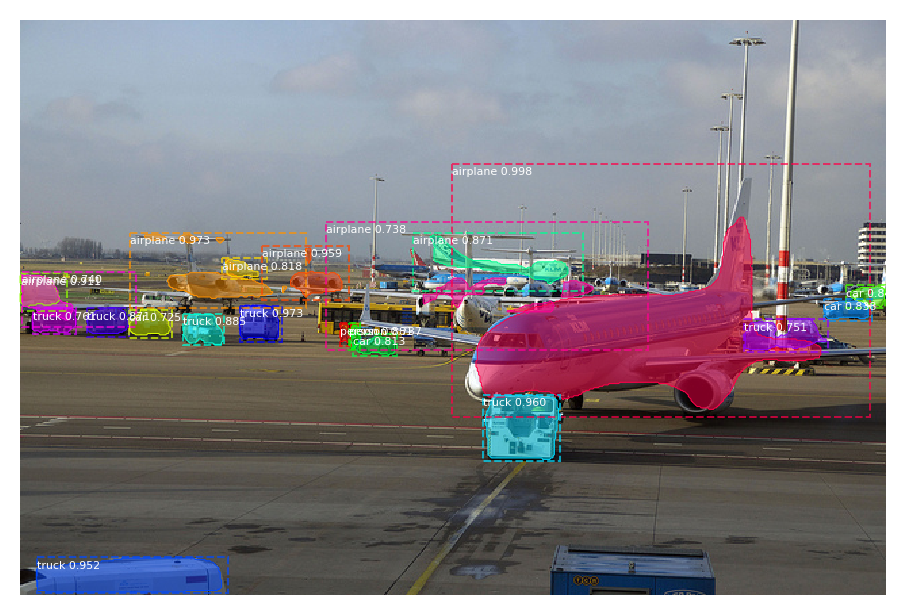

In [6]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])